Se importan las liberías necesarias

In [1]:
import tensorflow
import emnist
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
import matplotlib.pyplot as plt

import PIL
from keract import get_activations
from keract import display_activations


import glob
import matplotlib
from keras import models
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

Se crea una función que obtendrá una serie de datos aletarios para hacer el enetrenamiento y las pruebas. La función sirve para ambos casos: de entrada recibe las imágenes y las etiquetas de los datos de entramiento o los datos de pruebas y una variable n que define cuántos datos serán seleccionados para ser utilizados en la red neuronal convolucional.

In [2]:
def selec_random(images, labels, n):
    X = np.array([])
    y = np.array([])
    letter = np.array([])
    total_index = np.array([])
    index = 0
    for i in range(26):
        letter = np.array([])
        index = 0
        for k in labels:
            if i+1 == k:
                letter = np.append(letter,index)
            index = index + 1
        index2 = np.random.choice(letter, n, replace=False)
        index2 = index2.astype(int)
        total_index = np.append(total_index,index2)
    total_index = total_index.astype(int)
    total_index = np.sort(total_index)
    X = images[total_index[0]]
    y = labels[total_index[0]]
    total_index = np.delete(total_index, 0)
    X = X[np.newaxis, ...]
    for j in total_index:
        X = np.concatenate([X, images[j][None,...]], axis=0)
        y = np.append(y,labels[j])
    return X,y

Se obtienen los tipos de datos que el conjunto de datos EMNIST ofrece. De esta forma se reconce que el abecedario escrito a mano será en el dataset llamado 'letters'.

In [3]:
from emnist import list_datasets
list_datasets()

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']

Se obtienen los datos de entrenamiento dados por el conjunto de datos EMNIST y a su vez, por medio de la función selec_random se separan 100 de esos datos para utilizar en la red neuronal.

In [4]:
from emnist import extract_training_samples
images_train, labels_train = extract_training_samples('letters')
X_train, y_train = selec_random(images_train, labels_train, 100)
print("Dimensiones del array de entrada de entrenamiento:",X_train.shape)
print("Dimensiones del array de entrada de entrenamiento:",y_train.shape)

Dimensiones del array de entrada de entrenamiento: (2600, 28, 28)
Dimensiones del array de entrada de entrenamiento: (2600,)


De la misma forma se seleccionan 60 datos para las pruebas.

In [5]:
from emnist import extract_test_samples
images_test, labels_test = extract_test_samples('letters')
X_test, y_test = selec_random(images_test, labels_test, 60)
print("Dimensiones del array de entrada de pruebas:",X_test.shape)
print("Dimensiones del array de salida de pruebas:",y_test.shape)

Dimensiones del array de entrada de pruebas: (1560, 28, 28)
Dimensiones del array de salida de pruebas: (1560,)


Seguidamente se redimencionan las entradas, tanto las imágenes de entrenamiento como las de prueba. Esto es con el fin de que Keras pueda ser capaz de entrenar la red, pues esperan valores de píxeles con las dimensiones [píxeles] [ancho] [alto] [canales].

In [7]:
# reshape to be [samples][width][height][channels]
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1)).astype('float32')

In [8]:
X_train.shape

(2600, 28, 28, 1)

Se redimensionan las variables en entradas de 0 a 1 y a las salidas se les utiliza la función One Hot Encode para obtener una columna por cada salida.

In [9]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train2 = y_train
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

Esta parte define una función act_map. En ella se crea un array_i, que posee los índices de las letras en orden alfábetico. Por lo que el primer elemento del array corresponde a la primer letra 'a' que tiene los datos de entradas de entrenamiento y el último elemento posee la primer letra 'z' que aparece en los mismos datos. La creación de este array será útil para poder enseñar el mapa de activación. Así, por medio de cada índice del array_i se permite mostrar la imagen de cada letra.

Se define la función modelo de la red neuronal convolucional, donde k es un parámetro de entrada que recibirá la cantidad de núcleos de convolución. Además, se recibe un booleano llamado graf, si este es verdadero se mostrará el mapa de activación de una letra 

In [10]:
# define a simple CNN model
def baseline_model(k,pixel,pool):
    # create model
    model = Sequential()
    model.add(Conv2D(k, (pixel, pixel), input_shape=(28, 28, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(pool, pool)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Se crea y entrena el modelo de la red CNN.

In [11]:
# construcción del modelo
model = baseline_model(24,5,2)
# Fit the model
model.fit(X_train, y_train, epochs=30, verbose=2)
# Evaluación final del modelo
loss_var, accuracy_var = model.evaluate(X_test, y_test)

Epoch 1/30
82/82 - 1s - loss: 2.1088 - accuracy: 0.3912
Epoch 2/30
82/82 - 1s - loss: 1.1595 - accuracy: 0.6515
Epoch 3/30
82/82 - 1s - loss: 0.8657 - accuracy: 0.7404
Epoch 4/30
82/82 - 1s - loss: 0.6780 - accuracy: 0.7900
Epoch 5/30
82/82 - 1s - loss: 0.5367 - accuracy: 0.8408
Epoch 6/30
82/82 - 1s - loss: 0.4261 - accuracy: 0.8673
Epoch 7/30
82/82 - 1s - loss: 0.3476 - accuracy: 0.8823
Epoch 8/30
82/82 - 1s - loss: 0.2874 - accuracy: 0.8996
Epoch 9/30
82/82 - 1s - loss: 0.2345 - accuracy: 0.9250
Epoch 10/30
82/82 - 1s - loss: 0.1855 - accuracy: 0.9412
Epoch 11/30
82/82 - 1s - loss: 0.1563 - accuracy: 0.9481
Epoch 12/30
82/82 - 1s - loss: 0.1402 - accuracy: 0.9481
Epoch 13/30
82/82 - 1s - loss: 0.1130 - accuracy: 0.9681
Epoch 14/30
82/82 - 1s - loss: 0.0974 - accuracy: 0.9677
Epoch 15/30
82/82 - 1s - loss: 0.1022 - accuracy: 0.9696
Epoch 16/30
82/82 - 1s - loss: 0.0810 - accuracy: 0.9762
Epoch 17/30
82/82 - 1s - loss: 0.0622 - accuracy: 0.9812
Epoch 18/30
82/82 - 1s - loss: 0.0743 - 

In [143]:
from emnist import extract_training_samples
from emnist import extract_test_samples

images_train, labels_train = extract_training_samples('letters')
X_train = images_train
y_train = labels_train
X_train, y_train = selec_random(images_train, labels_train, 100)

images_test, labels_test = extract_test_samples('letters')
X_test = images_test
y_test = labels_test
X_test, y_test = selec_random(images_test, labels_test, 60)

num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape((X_train.shape[0], num_pixels)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], num_pixels)).astype('float32')
X_train = X_train / 255
X_test = X_test / 255
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# build the model
model = baseline_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/20
82/82 - 1s - loss: 1.8753 - accuracy: 0.4758 - val_loss: 1.3060 - val_accuracy: 0.6071
Epoch 2/20
82/82 - 1s - loss: 1.0730 - accuracy: 0.6769 - val_loss: 1.1223 - val_accuracy: 0.6737
Epoch 3/20
82/82 - 0s - loss: 0.7686 - accuracy: 0.7804 - val_loss: 1.0557 - val_accuracy: 0.6833
Epoch 4/20
82/82 - 1s - loss: 0.5628 - accuracy: 0.8431 - val_loss: 0.9915 - val_accuracy: 0.7006
Epoch 5/20
82/82 - 1s - loss: 0.4436 - accuracy: 0.8742 - val_loss: 0.9206 - val_accuracy: 0.7282
Epoch 6/20
82/82 - 0s - loss: 0.3135 - accuracy: 0.9246 - val_loss: 0.9147 - val_accuracy: 0.7276
Epoch 7/20
82/82 - 1s - loss: 0.2424 - accuracy: 0.9377 - val_loss: 0.9398 - val_accuracy: 0.7218
Epoch 8/20
82/82 - 1s - loss: 0.2086 - accuracy: 0.9469 - val_loss: 0.8797 - val_accuracy: 0.7487
Epoch 9/20
82/82 - 1s - loss: 0.1449 - accuracy: 0.9669 - val_loss: 0.8790 - val_accuracy: 0.7417
Epoch 10/20
82/82 - 1s - loss: 0.1081 - accuracy: 0.9796 - val_loss: 0.9007 - val_accuracy: 0.7487
Epoch 11/20
82/82 -

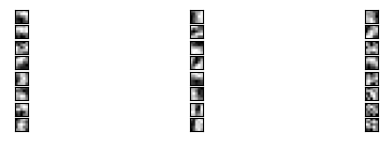

In [24]:
filters, biases = model.layers[0].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plot first few filters
n_filters, ix = 24, 1 ###############
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    # specify subplot and turn of axis
    ax = plt.subplot(n_filters, 3, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    plt.imshow(f[:, :, 0], cmap='gray')
    ix += 1
plt.show()

In [108]:
model2 = Model(inputs=model.inputs, outputs=model.layers[0].output)
#X_t = np.squeeze(X_train[0] , axis = 2)
X_t = X_train[0]
X_t.shape

(28, 28, 1)

In [113]:
arreglo = np.array([X_train[0],X_train[1]])
#arr_sq = np.squeeze(arreglo , axis = 2)
feature_maps = model2.predict(arreglo)
feature_maps.shape

(2, 24, 24, 24)

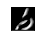

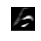

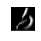

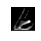

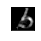

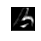

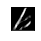

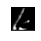

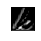

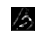

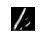

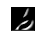

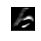

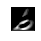

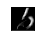

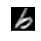

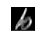

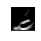

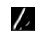

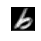

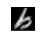

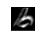

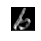

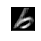

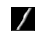

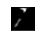

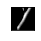

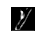

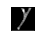

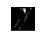

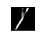

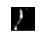

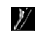

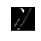

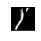

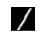

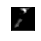

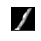

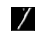

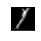

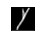

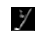

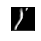

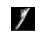

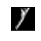

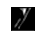

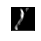

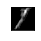

In [119]:
for i in feature_maps:  #################################
    for n in range(24):
        # specify subplot and turn of axis
        ax = plt.subplot(8, 8, 1)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(i[:, :, n], cmap='gray')
        plt.show()
        ix += 1
# show the figure

In [30]:
target_size=(512,512)
array_i = np.array([])
for i in range(26):
    index_i =  np.where(y == i+1)
    array_i = np.append(array_i,index_i[0][0])
array_i = array_i.astype(int)
for i in array_i:
    %matplotlib inline                                                              
    letter_i = i                                                                   # dato específico
    abc = X_train[letter_i ]                                                       # variable con imagen de entrenamiento específica
    #plt.imshow(abc, cmap='gray', interpolation='nearest')                             # impresión de variable
    #plt.show()
    #print("Image (#{}):".format(letter_i ))                                           # impresión de información y label



TypeError: 'Conv2D' object is not iterable